# Replicating ViT Food Vision Model

In [3]:
import torch
from torchvision import transforms

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/Assassinsoftomorrow/PyTorch_Course
    !mv PyTorch_Course/going_modular .
    !mv PyTorch_Course/helper_functions.py . # get the helper_functions.py script
    !rm -rf PyTorch_Course
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'PyTorch_Course'...
remote: Enumerating objects: 782, done.
remote: Total 782 (delta 0), reused 0 (delta 0), pack-reused 782
Receiving objects: 100% (782/782), 192.94 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (669/669), done.


In [5]:
# Getting Data
from helper_functions import download_data

image_path= download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [9]:
from going_modular.data_setup import create_dataloaders
BATCH_SIZE= 32

train_dataloader, test_dataloader, class_names= create_dataloaders(train_dir=train_dir,
                                                                   test_dir= test_dir,
                                                                   transform=manual_transforms,
                                                                   batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c2861687a90>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label= image_batch[0], label_batch[0]

# View the image shape and label
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

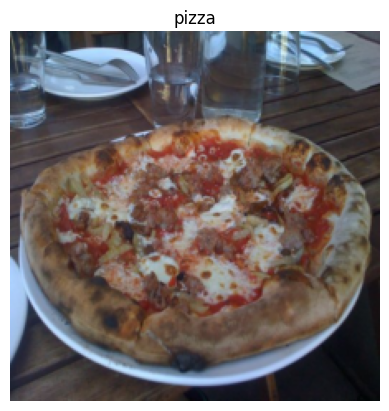

In [11]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # [color_channels, height, width] -> [height, width, color_channels])
plt.title(class_names[label])
plt.axis(False)

## 1. What's ViT made of?
There are 3 main resources for the architectural design:
1. **Figure 1** -  This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

### 1.1 Exploring Figure 1
The main things we'll be paying attention to are:

1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

![image.png](attachment:image.png) <i>Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.</i>

The ViT architecture is comprised of several stages:

- **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
- **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
- **Norm** - This is short for ["Layer Normalization"](https://paperswithcode.com/method/layer-normalization) or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
- **Multi-Head Attention** - This is a [Multi-Headed Self-Attention](https://paperswithcode.com/method/multi-head-attention) layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
- **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them (section 3.1) and a `torch.nn.Dropout()` layer after each (Appendex B.1).
- **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### 1.2 Exploring the 4 equations
The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

![image.png](attachment:image.png) *These four equations represent the math behind the four major parts of the ViT architecture.*

|**Equation number**|**Description from ViT paper section 3.1**|
|:------------------|------------------------------------------|
|1|	...The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings... Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings...**|
|2|	The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).|
|3|	Same as equation 2.|
|4|	Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** (z<sub>00</sub>=x<sub>class</sub> ), whose state at the output of the Transformer encoder (z0L) serves as the image representation y (Eq. 4)...|

#### 1.2.1 Equation 1 Overview
$$
\begin{aligned}
\mathrm{z}_0=\left[\mathrm{X}_{\mathrm{Class}} ; \mathrm{X}_{1 p} \mathrm{E}_i ; \mathrm{X}_{2 \mathrm{p}} \mathrm{E}_i ; \cdots ; \mathrm{X}_{\mathrm{Np}} \mathrm{E}\right]+\mathrm{E}_{\text {pos }}, \quad \mathrm{E} \in \mathrm{R}^{\left(P^2 \cdot \mathrm{C}\right) \times \mathrm{D}}, \mathrm{E}_{\text {pos }} \in \mathrm{R}^{(\mathrm{N}+1) \times \mathrm{D}} \\
z_0=\left[x_{\text {class }} ; x_p^1 E ; x_p^2 E ; \cdots ; x_p^N E\right]+E_{\text {pos }}, \quad E \in R^{\left(P^2 \cdot c\right) \times D}, E_{\text {pos }} \in R^{(N+1) \times D}
\end{aligned}
$$
This equation deals with the class token, patch embedding and position embedding ( $\varepsilon \varepsilon$ is for embedding) of the input image.

In vector form, the embedding might look something like:

``` python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```
Where each of the elements in the vector is learnable (their requires_grad=True).



#### 1.2.2 Equation 2 Overview
$$
z_{\ell}=\operatorname{MSA}\left(L N\left(z_{l-1}\right)\right)+z_{\ell-1}, \quad l=1 \ldots L
$$
$$
z_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(z_{\ell-1}\right)\right)+z_{\ell-1}, \quad \ell=1 \ldots L
$$
This says that for every layer from ${ }_{11}$ through to $u$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).


#### 1.2.3 Equation 3 Overview
$$
z_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(z_{\ell}\right)\right)+z_{\ell^{\prime}} \quad \ell=1 \ldots L
$$
$$
z_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(z_{\ell}^{\prime}\right)\right)+z_{\ell}^{\prime}, \quad \ell=1 \ldots L
$$
This says that for every layer from 11 through to $u$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:
```python
# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 1.2.4 Equation 4 Overview
$$
y=L N\left(z_{0 L}\right)
$$
$$
y=\operatorname{LN}\left(z_L^0\right)
$$
This says for the last layer $u$, the output $y$ is the 0 index token of $z z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```
Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

### 1.3  Exploring Table 1
| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
|-------|:------:|:---------------:|:--------:|:-----:|:------:|
|ViT-Base | 12   | 768    |  3072    | 12    | 86M     |
|ViT-Large| 24   | 1024   |  4096    | 16    | 307M    |
|ViT-Huge | 32   | 1280   |  5120    | 16    | 632M    |

*Table 1: Details of Vision Transformer model variants.* Source: [ViT paper](https://arxiv.org/pdf/2010.11929v2.pdf).

Breaking the hyperparameters down:

* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$**- This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
Heads - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

## 2. Equation 1: Split Data into patches and create the class, position and path embedding
Layers= input -> function -> output
* Input Shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output Shape:
> **Equation 1:** An overview of the model is depected in Figure 1. The standard Transformer recieves as input a 1D sequence of token embedding. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^ {H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $ \mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$ where $(H, W)$ is the resolution of the orignal image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W /P^{2}$ is the resulting number of patches, which also serves as the effective imput sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional imformations.  We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
* Input shape: $H \times{W}\times{C}$ (height x width x color channels)
* Output shape:  $N \times\left(P^{2} \cdot C\right)$
* H = height
* W = width
* C = color channels
* N = number of patches= (height * witdh)/ p^2
* D = constant latent vector size = embedding dimension (see Table 1)

### 2.1 Calculating patch embedding input and output shapes by hand

In [12]:
# Creating example values
height= 224
width= 224
color_channels= 3
patch_size= 16

# Calculate number of patches
number_of_patches= int((height* width) / patch_size**2)
number_of_patches

196

In [13]:
# Input Shape
embedding_layer_imput_shape= (height, width, color_channels)

# Output Shape
embedding_layer_output_shape= (number_of_patches, patch_size**2 * color_channels)
print(f"Input Shape (single 2D image): {embedding_layer_imput_shape}")
print(f"Output Shape (single 1D sequence patches): {embedding_layer_output_shape}")

Input Shape (single 2D image): (224, 224, 3)
Output Shape (single 1D sequence patches): (196, 768)


### 2.2 Turning images into patches

In [14]:
image.shape

torch.Size([3, 224, 224])

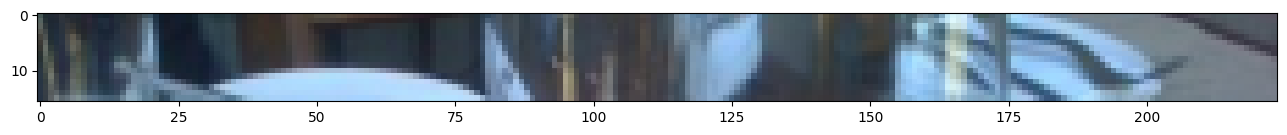

In [15]:
# Get the top of the row of the image
image_permuted= image.permute(1,2,0) # setting to (H, W, C)

# Index to pkit the top row of pixels
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch Size: 16 x 16 pixels


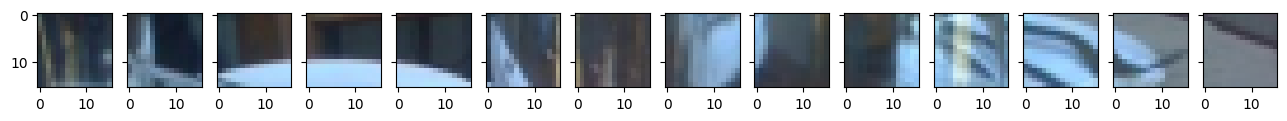

In [16]:
# Setup code to plot top row as patches
img_size= 224
num_patches= img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch Size: {patch_size} x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one colomn for each patch
                        sharex= True,
                        sharey= True,
                        figsize= (patch_size,patch_size))

# Iterate thriugh number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch Size: 16 x 16 pixels


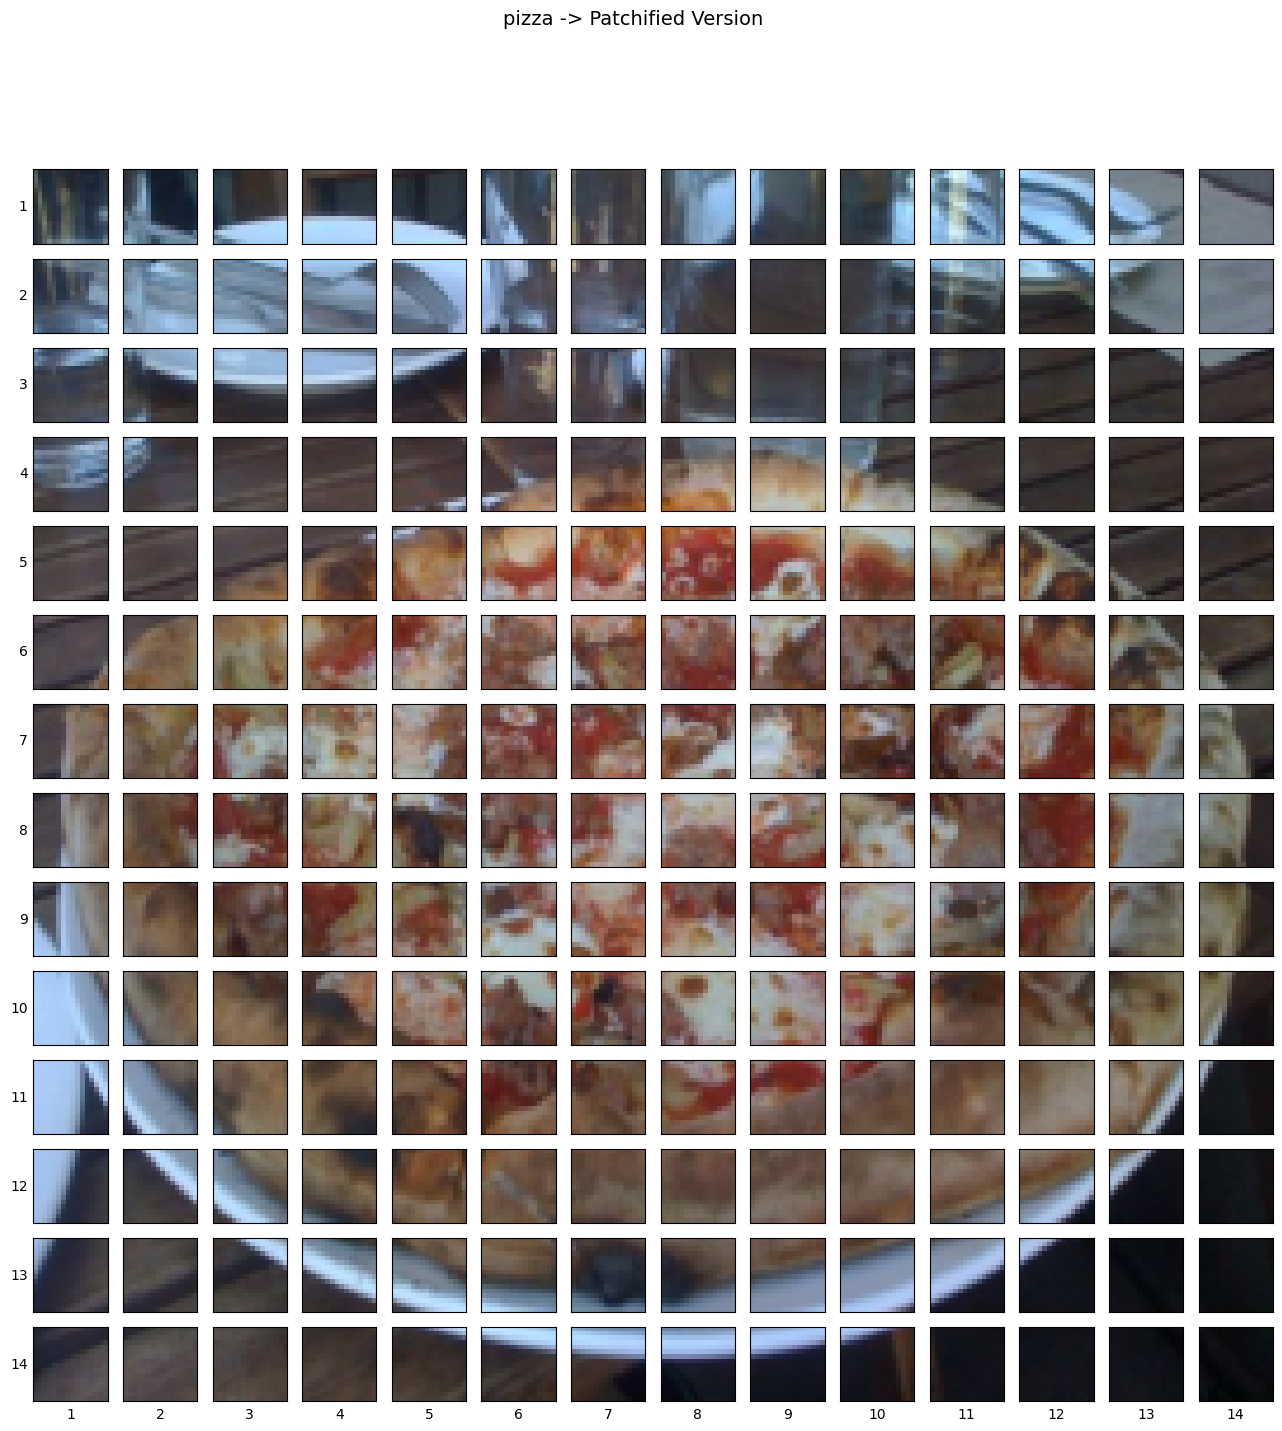

In [17]:
# Plotting the whole image as patches
print(f"Number of patches per row: {num_patches}")
print(f"Number of patches per column: {num_patches}")
print(f"Total patches: {num_patches*num_patches}\nPatch Size: {patch_size} x {patch_size} pixels")

fig, axs= plt.subplots(nrows= img_size// patch_size,
                       ncols= img_size// patch_size,
                       figsize= (patch_size, patch_size),
                       sharex= True,
                       sharey= True)
# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+ patch_size, #iterate through the height
                                        patch_width:patch_width+ patch_size, #iterate thriugh the width
                                        :]) #color channels
        # Setup label info for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                             rotation= 'horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')

        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified Version", fontsize= 14)
plt.show()

### 2.3 Creating image patches with `torch.nn.Conv2d()`
By setting the kernel size as `patch_size` and the stride as `patch_size`, we can create each patch as an embedding.

In [18]:
# Create a conv2D layer to turn images into patches of learnable feature maps (embeddings)
from torch import nn

# Creating a conv2D layer with the hyperparameters from the ViT paper
conv2d= nn.Conv2d(in_channels=3, # for color channels
               out_channels=768, # D size from Table 1. for ViT Base
               kernel_size= patch_size,
               stride=patch_size,
               padding= 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [19]:
# # View single image
# plt.imshow(image_permuted)
# plt.title(class_names[label])
# plt.axis(False)

In [20]:
# Pass the image through conv2D layer
img_out_of_conv= conv2d(image.unsqueeze(0)) #add batch dimensions -> [batch_size, color_channels, height, width]
print(img_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


After passing the image through the `nn.Conv2D` layer its shape is:
```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolution embeddings from indexes: [653, 322, 315, 526, 417]


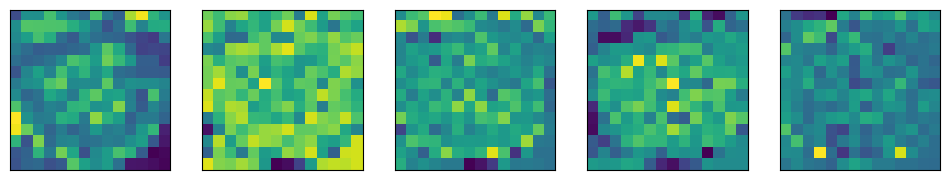

In [21]:
# plot random convolution feature maps (embeddings)
import random
random_indexes= random.sample(range(0,768), k=5)
print(f"Showing random convolution embeddings from indexes: {random_indexes}")

# Create a plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize= (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    img_conv_feature_map= img_out_of_conv[:, idx, :, :] # Index on the output tensor of the conv2d layer
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from gradient tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 2.4 Flatten the patch embedding with `torch.nn.Flatten()`
We have a series of convolutiona feature maps (embeddings) that we want to flatten into a sequence off patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [22]:
# Pass the image though the Flatten layer
print(f"Image shape out of the conv2d: {img_out_of_conv.shape} -> [batch_size, embedding dimensions, feature_map_height, feature_map_width]")
flatten_layer= nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(img_out_of_conv).shape

Image shape out of the conv2d: torch.Size([1, 768, 14, 14]) -> [batch_size, embedding dimensions, feature_map_height, feature_map_width]


torch.Size([1, 768, 196])

Orignal image shape: torch.Size([3, 224, 224])
Image feature map (embeddings/patches) shape: torch.Size([1, 768, 14, 14])
Flattened Image feature map: torch.Size([1, 768, 196])


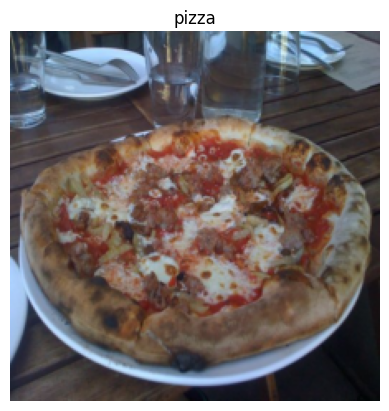

In [23]:
# Plot everything together
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)
print(f"Orignal image shape: {image.shape}")

# Turn image into feature maps
img_out_of_conv= conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (embeddings/patches) shape: {img_out_of_conv.shape}")

# Flatten feature maps
img_out_of_conv_flattened= flatten_layer(img_out_of_conv)
print(f"Flattened Image feature map: {img_out_of_conv_flattened.shape}")

In [24]:
# Rearrange output of the flatten layer
img_out_of_conv_flattened_permuted= img_out_of_conv_flattened.permute(0,2,1)
print(f"{img_out_of_conv_flattened_permuted.shape} -> [batch_size, number_of_patches, embedding_dimensions]")

torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimensions]


(-0.5, 195.5, 0.5, -0.5)

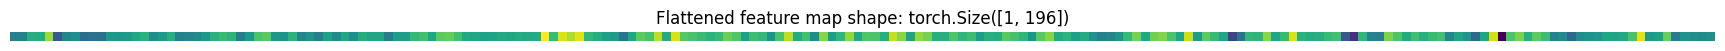

In [25]:
# Get a single flattened feature map
single_flattened_featrue_map= img_out_of_conv_flattened_permuted[:,:,0]

# Plot the flatten feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_featrue_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_featrue_map.shape}")
plt.axis(False)

### 2.5 Turning the ViT patch embedding layer into a PyTorch Module
We want this module to do a few things:
1. Create a class called `PatchEmbeddings` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, and patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (eg. pass through layer form 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embeddings.

In [26]:
# 1. Create a class called PatchEmbeddings
class PatchEmbeddings(nn.Module):
    # 2. Initialize the layer with appropriate hyper_parameters
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dimensions:int= 768) -> None: # From Table 1. for ViT-Base
        super().__init__()

        # 3. Create a layer to turn the image into embedding patches using Conv2d
        self.patcher= nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dimensions,
                               kernel_size= patch_size,
                               stride=patch_size,
                               padding=0)
        # 4. Create a layer to flatten feature map outputs of Conv2d()
        self.flatten= nn.Flatten(start_dim=2,
                                 end_dim=3)

    # 5. Define a forward method to define the forward computation steps
    def forward(self, x):
        # Create asseertion to check that inputs are the correct shape
        image_resolution= x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched= self.patcher(x)
        x_flattened= self.flatten(x_patched)
        # Setting the sequence embedding in the right order -> [batch_size, number_of_patches, embedding_dimensions]
        return(x_flattened.permute(0, 2, 1))

In [27]:
from helper_functions import set_seeds
set_seeds()

# Create an instance of the patch embedding layer
patchify= PatchEmbeddings(in_channels=3, patch_size= 16, embedding_dimensions= 768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image= patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### 2.6 Creating class tokens embedding
Want to: prependa learnable class token to the start of the patch embedding


In [28]:
patch_embedded_image

tensor([[[-0.2217,  0.0574, -0.1438,  ...,  0.1488, -0.0362,  0.1053],
         [-0.2778,  0.0428, -0.3153,  ...,  0.1987, -0.0135,  0.2619],
         [-0.2373,  0.2666, -0.4228,  ...,  0.5165, -0.1932,  0.0591],
         ...,
         [-0.0949,  0.0109, -0.0491,  ...,  0.0831, -0.0372,  0.0253],
         [-0.0790, -0.0077, -0.0624,  ...,  0.0634, -0.0212,  0.0309],
         [-0.0711,  0.0131, -0.0424,  ...,  0.0462, -0.0193,  0.0208]]],
       grad_fn=<PermuteBackward0>)

In [29]:
# Get the batch size and embedding dimension
batch_size= patch_embedded_image.shape[0]
emedding_dimension= patch_embedded_image.shape[-1]
batch_size, emedding_dimension

(1, 768)

In [30]:
# Create class token embedding as a learnable parameter that shares the same size as the emediing dimension (D)
class_token= nn.Parameter(torch.ones(batch_size, 1, emedding_dimension),
                          requires_grad= True)
class_token.shape

torch.Size([1, 1, 768])

In [31]:
# Add the class token in front of the patch embedding
patch_embedded_image_with_class_embedding= torch.cat((class_token, patch_embedded_image),
                                                     dim=1) # Number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape:{patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token +number_of_patches, embedding_dim )")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2217,  0.0574, -0.1438,  ...,  0.1488, -0.0362,  0.1053],
         [-0.2778,  0.0428, -0.3153,  ...,  0.1987, -0.0135,  0.2619],
         ...,
         [-0.0949,  0.0109, -0.0491,  ...,  0.0831, -0.0372,  0.0253],
         [-0.0790, -0.0077, -0.0624,  ...,  0.0634, -0.0212,  0.0309],
         [-0.0711,  0.0131, -0.0424,  ...,  0.0462, -0.0193,  0.0208]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape:torch.Size([1, 197, 768]) -> (batch_size, class_token +number_of_patches, embedding_dim )


### 2.7 Creating the position embeddings
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings

In [32]:
# Calculate N (number of patches)
number_of_patches= int((height* width) / patch_size**2)

# Get the embedding position
embedding_dimensions= patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding= nn.Parameter(torch.ones(1,number_of_patches+1, embedding_dimensions))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [33]:
# Add the position embedding to the patch and class token embeddings
patch_and_position_embeddings= patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embeddings)
print(f"Patch and position embedding shape:{patch_and_position_embeddings.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7783, 1.0574, 0.8562,  ..., 1.1488, 0.9638, 1.1053],
         [0.7222, 1.0428, 0.6847,  ..., 1.1987, 0.9865, 1.2619],
         ...,
         [0.9051, 1.0109, 0.9509,  ..., 1.0831, 0.9628, 1.0253],
         [0.9210, 0.9923, 0.9376,  ..., 1.0634, 0.9788, 1.0309],
         [0.9289, 1.0131, 0.9576,  ..., 1.0462, 0.9807, 1.0208]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape:torch.Size([1, 197, 768])


### 4.8 Putting it all together: from imaage to embedding
We've written code to turn an image into a flattened sequence of patch embeddings

In [34]:
# Set seed
set_seeds()

# 1. Set patch size
patch_size= 16

# 2. Print shape of orignal image tensor and get the image dimensions
print(f"Shape of image: {image.shape}")

# 3. Get image tensor and add batch size
x= image.unsqueeze(0)
print(f"Shape of image after adding the batch:{x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer= PatchEmbeddings()

# 5. Pass image through patch embedding layer
patch_embedding= patch_embedding_layer(x)
print(f"Patch Embedded Image Shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size= patch_embedding.shape[0]
embedding_dimension= patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                         requires_grad= True) # make sure it is learnable
print(f"Class Token Shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token= torch.cat((class_token, patch_embedding), dim=1)
print(f"Class Embedding Token Shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches= int((height * width) / patch_size**2)
position_embedding= nn.Parameter(torch.ones(1, number_of_patches +1, embedding_dimension),
                                 requires_grad= True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding= patch_embedding_class_token+ position_embedding
print(f"Patch and Position Embedding Shape: {patch_and_position_embedding.shape}")

Shape of image: torch.Size([3, 224, 224])
Shape of image after adding the batch:torch.Size([1, 3, 224, 224])
Patch Embedded Image Shape: torch.Size([1, 196, 768])
Class Token Shape: torch.Size([1, 1, 768])
Class Embedding Token Shape: torch.Size([1, 197, 768])
Patch and Position Embedding Shape: torch.Size([1, 197, 768])


## 3. Equation 2: Multi-Head Attention (MSA)
* Multi-Head Attention: which part of a sequence should you pay the most attention to itself?
    - In out case, we have series of embedded image patches, which patch significantly relates to another patch?
    - We want our Neural Network (ViT) to learn this relationship/representation.
* To replicate this we can use the [`torch.nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
* LayerNorm: Layer normalisation is a technique to normalize the distrebutions of intermdeiate  layers. It enables smoother gradients, faster training, and better generalization accuracy.
    - Normalization: makes everything have the same mean and same standard deviation.
    - In pytorch, we have [`torch.nn.LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), which normalizes values over $D$ dimension, in our case the $D$ is the embedding dimension.

#### Equation 2
$$
\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L
$$

In [35]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dimension: int=768, # Hidden size D (embedding dimension) from Table 1 for ViT Base
                 num_heads:int=12, # Heads from Table 1 for ViT Base
                 attn_dropout: int=0)-> None:
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dimension)

        # Create multihead attention (MSA) layer
        self.multihead_attn= nn.MultiheadAttention(embed_dim= embedding_dimension,
                                                   num_heads= num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True) # is the batch first? -> (batch_size, number_of_patches/seq, embedded_dim)

    def forward(self,x):
        x= self.layer_norm(x)
        attention_output, _= self.multihead_attn(query=x,
                                                 key=x,
                                                 value=x,
                                                 need_weights= False)
        return(attention_output)

In [36]:
# Create an instance of MSA Block
multihead_self_attention_block= MultiheadSelfAttentionBlock(embedding_dimension=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through the MSA Block
patched_image_through_msa_block= multihead_self_attention_block(patch_and_position_embedding)
print(f"Input Shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output Shape of MSA block:{patched_image_through_msa_block.shape}")

Input Shape of MSA block: torch.Size([1, 197, 768])
Output Shape of MSA block:torch.Size([1, 197, 768])


In [37]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7783, 1.0574, 0.8562,  ..., 1.1488, 0.9638, 1.1053],
         [0.7222, 1.0428, 0.6847,  ..., 1.1987, 0.9865, 1.2619],
         ...,
         [0.9051, 1.0109, 0.9509,  ..., 1.0831, 0.9628, 1.0253],
         [0.9210, 0.9923, 0.9376,  ..., 1.0634, 0.9788, 1.0309],
         [0.9289, 1.0131, 0.9576,  ..., 1.0462, 0.9807, 1.0208]]],
       grad_fn=<AddBackward0>)

### 4. Equation 3: Multilayer Perceptron (MLP) Block
* **MLP:** The MLP contains two layers with a GELU non-linearity (section 3.1)
    - MLP is a  quite broad term for a block with a series of layer(s). Layers can be multiple or even only one hidden layer.
    - Layers can mean fully connected, dense, linear, feed-forward. All are often similar names for the same thing. In PyTorch they are commonly reffered as `torch.nn.Linear()` and in TensorFlow they might be called `tf.kears.layers.Dense()`
    > Value for MLP available in Table 1
    - GELU in PyTorch is called through [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html)
* **Dropout:** Dropout, when used, is applied after every dense/linear layer except for the query-key-value (qvk) and directly after adding positional to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts. (Taken from the ViT Paper)
> Value for Dropout available in Table 3

Pseudocode:
```python
x= linear -> non-linear -> dropout -> linear -> dropout
```

#### Equation 3
$$
\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L
$$


In [38]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int= 768, # From Table 1 for ViT Base
                 mlp_size: int=3072, # From Table 1 for ViT Base
                 dropout: int=0.1 # From Table 3 for ViT Base
                 ) -> None:
        super().__init__()

        # Create the norm layer
        self.norm_layer= nn.LayerNorm(normalized_shape=embedding_dimension)

        # Create the MLP layer
        self.mlp= nn.Sequential(
            nn.Linear(in_features=embedding_dimension, out_features= mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dimension),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        # x= self.norm_layer(x)
        # x= self.mlp(x)

        # return x
        return self.mlp(self.norm_layer(x)) # same as above

In [39]:
# Create an instance of the MLP Block
mlp_block= MLPBlock(embedding_dimension=768,
                    mlp_size=3072,
                    dropout=0.1)

# Pass output of the MSA Block through the MLP Block
patched_image_through_mlp_block= mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP Block: {patched_image_through_msa_block.shape}")
print(f"Output Shape of the MLP Block: {patched_image_through_mlp_block.shape}")

Input shape of MLP Block: torch.Size([1, 197, 768])
Output Shape of the MLP Block: torch.Size([1, 197, 768])


## 5. Transformer Encoder: MSA Block + MLP Block
The transformer encoder is an alternating block of MSA (Equation 2) and MLP blocks (Equation 3) + the residual connection.

Pseudocode
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_output + x_input] -> MLP_block -> [MSA_output + MLP_output + x_input] -> ...
```

### 5.1 Create a custom Transform Encoder Block

In [40]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int= 768, # Hidden size D from Table 1 for Vit Base
                 num_heads: int=12, # Table 1
                 mlp_size: int=3072, # Table 1
                 mlp_dropout: int= 0.1, # Table 3
                 dropout: int=0) -> None:
        super().__init__()

        # Create MSA Block (Equation 2)
        self.msa_block= MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,
                                                    num_heads=num_heads,
                                                    attn_dropout=dropout)

        # Create MLP Block
        self.mlp_block= MLPBlock(embedding_dimension=embedding_dimension,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)

    def forward(self, x):
        # x= self.msa_block(x) + x # residual/skip connections
        # x= self.mlp_block(x) + x # residual/skip connections
        # return (x)
        return (self.mlp_block(self.msa_block(x)+x)+x) # same as above

In [41]:
from torchinfo import summary
# Create an instance of the Transformer Encoder
transformer_encoder_block= TransformerEncoderBlock(embedding_dimension=768,
                                                   num_heads=12,
                                                   mlp_size=3072,
                                                   mlp_dropout=0.1,
                                                   dropout=0)

# Get a summary of the transformer encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches/ seq, embedding_dim)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 5.2 Create a transformer Encoder Layer with Inbuilt PyTirch Layers
PyTorch has ready to use Transformer Encoder Layer. [Transformer Layers](https://pytorch.org/docs/stable/nn.html#transformer-layers)

In [42]:
torch_transformer_encoder_layer= torch.nn.TransformerEncoderLayer(d_model=768, # embedding dimension or D from Table 1
                                                                  nhead=12, # heads from table 1
                                                                  dim_feedforward=3072, # mlp size from Table 1
                                                                  dropout=0.1,
                                                                  activation='gelu',
                                                                  batch_first= True,
                                                                  norm_first= True)
# Get a summary of the transformer encoder
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches/ seq, embedding_dim)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [43]:
# clearing the GPU cache to make space for GPU training
torch.cuda.empty_cache()

## 6. Putting it all together

In [44]:
# Create a ViT Class
class ViT(nn.Module):
    def __init__(self,
                 image_size: int=224, # Size according to the paper (Table 3)
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12, # Table 1 for ViT Base
                 embedding_dimension: int=768, # Hidden size D from Table 1
                 num_heads: int=12, # Table 1
                 attn_dropout: int=0, # Table 1
                 mlp_size: int= 3072, # Table 1
                 mlp_dropout: int= 0.1, # Table 3
                 embedding_dropout: int=0.1, # Dropout for patch and postion embeddings
                 num_classes: int= 1000 # Number of classes
                ) -> None:
        super().__init__()

        # Make sure the image size is compatible with the patch size
        assert image_size % patch_size == 0, f"Image Size nust be divisable by patch size, image: {image_size}, patch size: {patch_size}"

        # Calculate the number of patches [(height * width)/patch^2]
        self.number_of_patches= image_size*image_size//patch_size**2

        # Create learnable class embeddings (needs to go in front of sequence of patch embeddings)
        self.class_embedding= nn.Parameter(data=torch.rand(1, 1, embedding_dimension),
                                           requires_grad= True)

        # Create position embedding
        self.position_embedding= nn.Parameter(data=torch.rand(1, self.number_of_patches+1, embedding_dimension),
                                              requires_grad= True)

        # Create embedding dropout values
        self.embedding_dropout= nn.Dropout(p=embedding_dropout)

        # Patch embedding layer
        self.patch_embedding= PatchEmbeddings(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dimensions=embedding_dimension)

        # Create the transformer encoder block
        self.transformer_encoder= nn.Sequential(*[TransformerEncoderBlock(embedding_dimension=embedding_dimension,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout,
                                                                          dropout=attn_dropout) for _ in range(num_transformer_layers)])

        # Create classifier layer
        self.classifier= nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dimension),
                                       nn.Linear(in_features=embedding_dimension, out_features=num_classes))

    def forward(self, x):
        # Get the batch size
        batch_size= x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token= self.class_embedding.expand(batch_size, -1, -1) # '-1' means to infer the dimensions

        # Create the patch embeddings
        x= self.patch_embedding(x)

        # Concat class token embedding and patch embedding (Equation 1)
        x= torch.concat((class_token,x), dim=1) # (batch_size, number_of_patches+1, embedding_dim)

        # Apply dropout to patch embedding (directly after adding positional- to patch embeddings)
        x=self.embedding_dropout(x)

        # Pass position and patch embedding to transformer encoder (Equation 2 and 3)
        x= self.transformer_encoder(x)

        # Put the 0th index logit throught the MLP Head (Equation 4)
        x= self.classifier(x[:,0]) # run on each sample in a batch at 0 index
        return (x)



In [45]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [46]:
set_seeds()

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

### 6.1 Getting a visual summary of our ViT model

In [47]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbeddings (patch_embedding)                          [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 7. Setting up training code for our custom ViT
We've replicated the ViT architechture, now let's see how it performs on our FoodVision Mini data.

### 7.1 Creating Optimizer and Loss Function
The paper uses adam optimizer with the learning rate of 10e-3 and weight decay of 0.03. The paper does not specify the loss function, but since we have mulitclass classification, it is usually `CrossEntropyLoss`

In [48]:
from going_modular.engine import train

optimizer= torch.optim.Adam(params=vit.parameters(),
                            lr=1e-3,
                            weight_decay=0.1)

loss_fn= torch.nn.CrossEntropyLoss()

results= train(model=vit,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=10,
               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4396 | train_acc: 0.2852 | test_loss: 1.1242 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.3258 | train_acc: 0.2773 | test_loss: 1.4427 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2028 | train_acc: 0.4102 | test_loss: 1.1117 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5728 | train_acc: 0.2734 | test_loss: 1.0089 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.2804 | train_acc: 0.4062 | test_loss: 2.3508 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.4568 | train_acc: 0.4453 | test_loss: 1.2290 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.4684 | train_acc: 0.2773 | test_loss: 1.0733 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1683 | train_acc: 0.3242 | test_loss: 1.7341 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3973 | train_acc: 0.2852 | test_loss: 1.6733 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.3192 | train_acc: 0.2656 | test_loss: 1.0562 | test_acc: 0.5417


### 7.2 What is the training setup missing?
How is the setup differen to the ViT paper?

We've replicated the paper correctly.

But what was the difference between our training procedure (to get comparitively poor results) and the ViT paper training procedure to get such great results.
* Bigger datasets
* Longer training period
* Smaller batch size

|Hyperparameter value |	ViT Paper	Our | implementation |
|---------------------|---------------|----------------|
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) |	225 |
| Epochs	| 7 (for largest dataset), 90, 300 (for ImageNet) |	10 |
| Batch size |	4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) |	10k steps (Table 3) |	None |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.)	| Linear/Cosine (Table 3) |	None |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) |	Global norm 1 (Table 3) |	None |

### 7.3 Plotting loss curves for our model

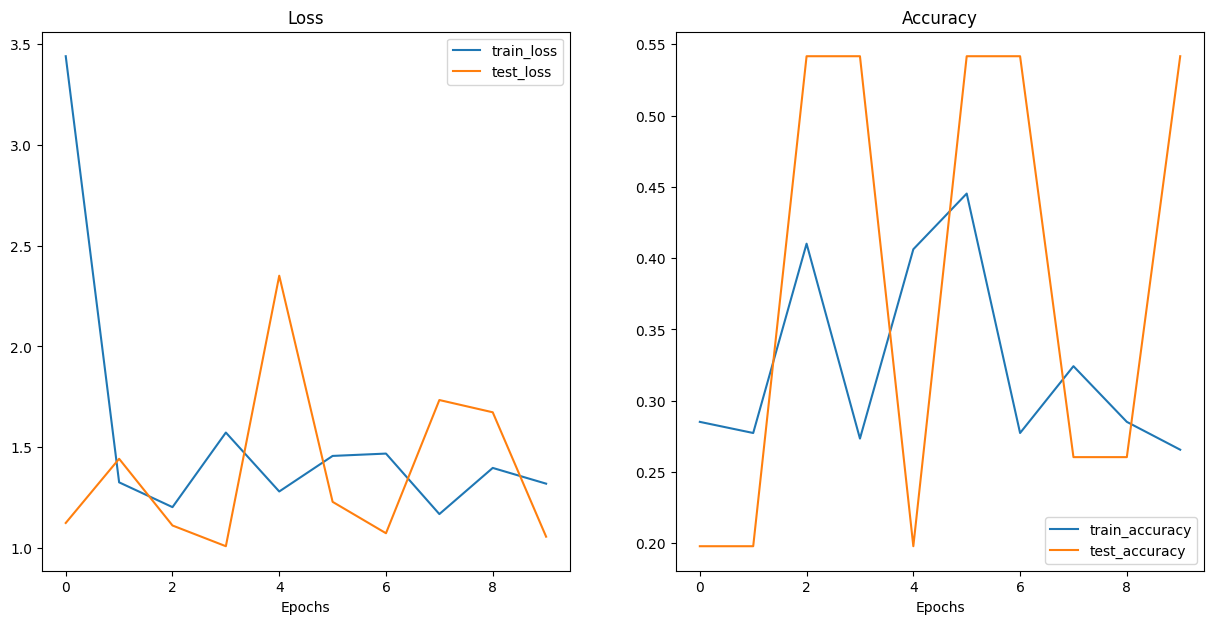

In [49]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 8 Pretrained ViT

### 8.1 Using the pretrained ViT model and weights

In [50]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [51]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [55]:
# Get pre-trained weights for ViT-Base
pretrained_vit_weights= torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit= torchvision.models.vit_b_16(weights= pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameters in pretrained_vit.parameters():
  parameters.requires_grad= False

# Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [56]:
summary(model= pretrained_vit,
        input_size= (1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names= ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 8.2 Preparing data for the pretrained model

In [57]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [58]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [59]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [60]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 8.3 Train feature extractor ViT model
As before we'll use the Adam optimizer (`torch.optim.Adam()`) with a learning rate of `1e-3` and `torch.nn.CrossEntropyLoss()` as the loss function.

Our `engine.train()` function we created in 05. PyTorch Going Modular section 4 will take care of the rest.
> The training was done on [google colab](https://colab.research.google.com/) since the device GPU did not have enough RAM to train the code.

In [61]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 8.4 Plot feature extractor ViT model loss curves

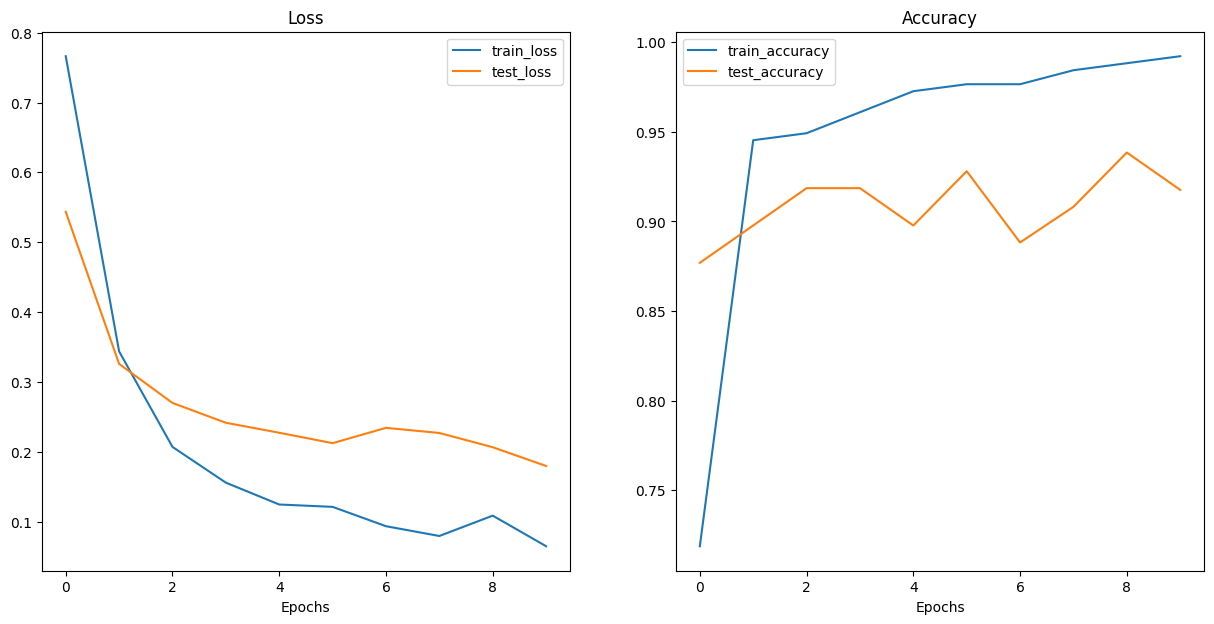

In [62]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 8.5 Save feature extractor ViT model and check file size
ViT feature extractor model is performing quite well for our Food Vision Mini problem

If we want to deploy the model, we first need to save the model with `utils.save_model()` function created in theh 05. PyTorch Going Modular


In [63]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


Since we're thinking about deploying this model, it'd be good to know the size of it (in megabytes or MB).

Since we want our Food Vision Mini application to run fast, generally a smaller model with good performance will be better than a larger model with great performance.

We can check the size of our model in bytes using the `st_size` attribute of Python's `pathlib.Path().stat()` method whilst passing it our model's filepath name.

We can then scale the size in bytes to megabytes.

In [64]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


|Model |	Model size (MB) |	Test loss |	Test accuracy |
|------|------------------|-----------|---------------|
|EffNetB2 feature extractor |	29 |	~0.3906 |	~0.9384 |
|ViT feature extractor |	327 |	~0.1084	 |~0.9384 |

EffNetB2 model is ~11x smaller than the ViT model with similiar results for test loss and accuracy.

However, the ViT model's results may improve more when trained with the same data (20% pizza, steak and sushi data).

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size?

Perhaps such a large model would take longer to load/run and wouldn't provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

## 9. Making Predictions on a custom image

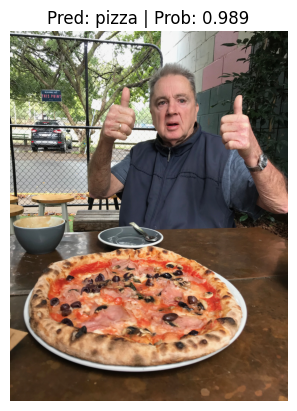

In [66]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)